In [24]:
import gc
import pathlib
from typing import Dict, List, Tuple, Union
import sys

from joblib import load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

sys.path.append('..')

from scripts.evaluate import Evaluator
from scripts.get_depth_paths import get_depth_paths
from scripts.get_logger import get_logger
from scripts.merge_dataset import merge_dataset

gc.enable()
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

In [25]:
class PathHandler:
    competition_dir = pathlib.Path('../../inputs')
    parquet_files_dir = competition_dir.joinpath('parquet_files')
    feature_dir = pathlib.Path('../../outputs/features')
    model_dir = sorted(
        [p for p in pathlib.Path('../../outputs/output_catboost').glob('model_outputs*')]
    )[-1]


paths = PathHandler()

- P - Transform DPD (Days past due)
- M - Masking categories
- A - Transform amount
- D - Transform date
- T - Unspecified Transform
- L - Unspecified Transform

In [26]:
bool_features = pd.read_csv(paths.feature_dir.joinpath('bool_features.csv'))
float64_features = pd.read_csv(paths.feature_dir.joinpath('float64_features.csv'))
string_features = pd.read_csv(paths.feature_dir.joinpath('string_features.csv'))
date_features = pd.read_csv(paths.feature_dir.joinpath('date_features.csv'))

bool_features['cast_dtype'] = pl.Int8
float64_features['cast_dtype'] = pl.Float32
string_features['cast_dtype'] = pl.String
date_features['cast_dtype'] = pl.Date

cast_features = pd.concat([bool_features, float64_features, string_features])
display(cast_features)

Variable  \
0              remitter_829L   
1   contaddr_matchlist_1032L   
2         isbidproduct_1095L   
3           isdebitcard_729L   
4   contaddr_smempladdr_334L   
..                       ...   
94          addres_role_871L   
95    cacccardblochreas_147M   
96  relatedpersons_role_762T   
97        riskassesment_302T   
98         employername_160M   

                                                                                            Description  \
0                                                     Flag indicating whether the client is a remitter.   
1                                        Indicates whether the contact address is found in a code list.   
2                                                       Flag indicating if the product is a cross-sell.   
3                                                       Flag indicating if the product is a debit card.   
4                          Indicates whether the contact address is the same as the employment address.   
..                                                                                                  ...   
94                                                                            Role of person's address.   
95                                                                                Card blocking reason.   
96   Relationship type of a client's related person (num_group1 - person, num_group2 - related person).   
97  Estimated probability that the client will default on their credit obligation within the next year.   
98                                                                                     Employer's name.   

    train_num_unique_values train_unique_types  train_num_nan  \
0                         2               bool        2168942   
1                         2               bool        1447773   
2                         2               bool              0   
3                         2               bool        1334357   
4                         3               bool        1447773   
..                      ...                ...            ...   
94                        9                str        1575736   
95                       10                str         109249   
96                       11                str        1614684   
97                       17                str        1446917   
98                   152835                str              0   

             train_files  train_num_unique_types  test_num_unique_values  \
0           ['person_1']                       1                       2   
1           ['person_1']                       1                       2   
2           ['static_0']                       1                       2   
3           ['static_0']                       1                       2   
4           ['person_1']                       1                       2   
..                   ...                     ...                     ...   
94          ['person_2']                       1                       1   
95        ['applprev_2']                       1                       1   
96          ['person_2']                       1                       1   
97       ['static_cb_0']                       1                       1   
98  ['tax_registry_c_1']                       1                       0   

   test_unique_types  test_num_nan            test_files  \
0               bool             7          ['person_1']   
1               bool             7          ['person_1']   
2               bool             0          ['static_0']   
3               bool             9          ['static_0']   
4               bool             7          ['person_1']   
..               ...           ...                   ...   
94               NaN            10          ['person_2']   
95               NaN            10        ['applprev_2']   
96               NaN            10          ['person_2']   
97               NaN            10       ['static_cb_0']

In [27]:
display(string_features.query('transform=="M"'))

Variable  \
4              description_5085714M   
5                    language1_981M   
16  collater_typofvalofguarant_298M   
17                    education_88M   
18                  education_1103M   
19                  subjectrole_43M   
20                 subjectrole_326M   
21                   maritalst_893M   
22                  education_1138M   
23                   education_927M   
26                   maritalst_385M   
28  collater_typofvalofguarant_407M   
30           subjectroles_name_838M   
31                 subjectrole_182M   
32                 postype_4733339M   
33                  subjectrole_93M   
34          empls_economicalst_849M   
37      classificationofcontr_1114M   
38                   pmtmethod_731M   
39        classificationofcontr_13M   
41           subjectroles_name_541M   
43           periodicityofpmts_997M   
44                   conts_role_79M   
46                 description_351M   
48  lastrejectreasonclient_4145040M   
49      rejectreasonclient_4145042M   
50                  contractst_516M   
51  collaterals_typeofguarante_359M   
52  collaterals_typeofguarante_669M   
53               purposeofcred_722M   
54            lastrejectreason_759M   
55                rejectreason_755M   
56               purposeofcred_426M   
57               purposeofcred_874M   
58                contracttype_653M   
60      lastrejectcommoditycat_161M   
61       lastapprcommoditycat_1041M   
62                  contractst_545M   
63            lastcancelreason_561M   
64            cancelreason_3545846M   
65                  credor_3940957M   
66   lastrejectcommodtypec_5251769M   
67  lastapprcommoditytypec_5251766M   
68           empladdr_district_926M   
69        previouscontdistrict_112M   
70        financialinstitution_591M   
71                  contractst_964M   
72       classificationofcontr_400M   
73        financialinstitution_382M   
74             addres_district_368M   
75            contaddr_district_15M   
76        registaddr_district_1083M   
77                    district_544M   
78                  addres_zip_823M   
79            empladdr_zipcode_114M   
80            contaddr_zipcode_807M   
81          registaddr_zipcode_184M   
82         empls_employer_name_740M   
83                  profession_152M   
84                    name_4917606M   
85                    name_4527232M   
95           cacccardblochreas_147M   
98                employername_160M   

                                                                                                       Description  \
4                                                                      Categorization of clients by credit bureau.   
5                                                                              The primary language of the person.   
16                                                                    Collateral valuation type (active contract).   
17                                                                                  Education level of the client.   
18                                                   Level of education of the client provided by external source.   
19                                                                         Subject role in closed credit contract.   
20                                                                         Subject role in active credit contract.   
21                                                                                    Marital status of the client   
22                                                    Applicant's education level from their previous application.   
23                                                                                  Education level of the person.   
26                                                                                   Marital status of the client.   
28                                                                    Collateral valuation type (closed contract).

### load feature definition, out-of-fold and feature importances.

In [28]:
feature_definition = pd.read_csv(paths.competition_dir.joinpath('feature_definitions.csv'))
oof = pd.read_csv(paths.model_dir.joinpath('oof.csv'))
outcome = pd.read_csv(paths.model_dir.joinpath('outcome.csv'))
fimps = pd.read_csv(paths.model_dir.joinpath('feature_importances.csv'), index_col='processed_Variable')

base_variables = []
for v1 in feature_definition['Variable'].to_list():
    for v2 in fimps.index.to_list():
        if v1 in v2:
            base_variables.append((v2, v1))
base_variables = pd.DataFrame(base_variables)
base_variables.columns = ['processed_Variable', 'Variable']
fimps = fimps.merge(base_variables, on='processed_Variable')
fimps = fimps.merge(feature_definition, left_on='Variable', right_on='Variable')
fimps['transform'] = fimps['Variable'].map(lambda x: x[-1])
fimps['depth'] = fimps['processed_Variable'].map(lambda x: x[-1])

display(fimps)
display(feature_definition)
display(oof)
display(outcome)

processed_Variable  fold_1_fimp  fold_2_fimp  \
0              median_personindex_1023L_1     0.006243     0.008371   
1               max_residualamount_488A_1     0.016874     0.038283   
2             sum_ratio_pmts_month_706T_2     0.028348     0.033038   
3         year_lastapplicationdate_877D_0     0.041478     0.042233   
4    first_first_cacccardblochreas_147M_2     0.047713     0.035007   
..                                    ...          ...          ...   
295                         pmtnum_254L_0     2.027380     2.000556   
296                      first_sex_738L_1     1.986439     2.088416   
297               year_first_birth_259D_1     1.814685     2.146729   
298                         price_1097A_0     2.090621     2.346714   
299              first_incometype_1044T_1     2.373700     2.295061   

     fold_3_fimp  fold_4_fimp  fold_5_fimp  fimp_mean  fimp_std  \
0       0.017491     0.009391     0.006134   0.009526  0.004173   
1       0.015361     0.029374     0.016138   0.023206  0.009132   
2       0.036308     0.021456     0.031899   0.030210  0.005062   
3       0.030510     0.039590     0.043192   0.039401  0.004600   
4       0.049492     0.054861     0.044474   0.046309  0.006578   
..           ...          ...          ...        ...       ...   
295     2.162102     1.577300     2.055565   1.964581  0.201254   
296     1.980769     2.044951     1.972626   2.014640  0.044876   
297     2.153961     1.993088     2.114035   2.044500  0.128628   
298     1.964416     1.988609     1.864001   2.050872  0.164545   
299     2.333860     2.386170     2.362060   2.350170  0.032540   

                     Variable  \
0           personindex_1023L   
1         residualamount_488A   
2             pmts_month_706T   
3    lastapplicationdate_877D   
4      cacccardblochreas_147M   
..                        ...   
295               pmtnum_254L   
296                  sex_738L   
297                birth_259D   
298               price_1097A   
299          incometype_1044T   

                                                                                        Description  \
0                                            Order of the person specified on the application form.   
1                                                             Residual amount of a closed contract.   
2    Month of payment for active contract (num_group1 - terminated contract, num_group2 - payment).   
3                                                          Date of previous customer's application.   
4                                                                             Card blocking reason.   
..                                                                                              ...   
295                                               Total number of loan payments made by the client.   
296                                                                           Gender of the client.   
297                                                                    Date of birth of the person.   
298                                                                                   Credit price.   
299                                                                    Type of income of the person   

    transform depth  
0           L     1  
1           A     1  
2           T     2  
3           D     0  
4           M     2  
..        ...   ...  
295         L     0  
296         L     1  
297         D     1  
298         A     0  
299         T     1  

[300 rows x 12 columns]

Variable  \
0              actualdpd_943P   
1     actualdpdtolerance_344P   
2        addres_district_368M   
3            addres_role_871L   
4             addres_zip_823M   
..                        ...   
460  totinstallast1m_4525188A   
461        twobodfilling_608L   
462                  type_25L   
463            typesuite_864L   
464           validfrom_1069D   

                                                              Description  
0                      Days Past Due (DPD) of previous contract (actual).  
1                                           DPD of client with tolerance.  
2                                       District of the person's address.  
3                                               Role of person's address.  
4                                                Zip code of the address.  
..                                                                    ...  
460       Total amount of monthly instalments paid in the previous month.  
461                                          Type of application process.  
462                                             Contact type of a person.  
463  Persons accompanying the client during the loan application process.  
464                         Date since the client has an active campaign.  

[465 rows x 2 columns]

case_id date_decision   MONTH  WEEK_NUM  target  probability  fold
0              0    2019-01-03  201901         0       0     0.038270   0.0
1              1    2019-01-03  201901         0       0     0.051017   0.0
2              2    2019-01-04  201901         0       0     0.047300   0.0
3              3    2019-01-03  201901         0       0     0.075348   0.0
4              4    2019-01-04  201901         0       1     0.071538   0.0
...          ...           ...     ...       ...     ...          ...   ...
1526654  2703450    2020-10-05  202010        91       0     0.001319   0.0
1526655  2703451    2020-10-05  202010        91       0     0.004464   0.0
1526656  2703452    2020-10-05  202010        91       0     0.053439   0.0
1526657  2703453    2020-10-05  202010        91       0     0.001841   0.0
1526658  2703454    2020-10-05  202010        91       0     0.004428   0.0

[1526659 rows x 7 columns]

stability     slope  intercept
0   0.693898  0.000774   0.673017

### show feature importances

processed_Variable  fold_1_fimp  fold_2_fimp  \
0              median_personindex_1023L_1     0.006243     0.008371   
1               max_residualamount_488A_1     0.016874     0.038283   
2             sum_ratio_pmts_month_706T_2     0.028348     0.033038   
3         year_lastapplicationdate_877D_0     0.041478     0.042233   
4    first_first_cacccardblochreas_147M_2     0.047713     0.035007   
..                                    ...          ...          ...   
295                         pmtnum_254L_0     2.027380     2.000556   
296                      first_sex_738L_1     1.986439     2.088416   
297               year_first_birth_259D_1     1.814685     2.146729   
298                         price_1097A_0     2.090621     2.346714   
299              first_incometype_1044T_1     2.373700     2.295061   

     fold_3_fimp  fold_4_fimp  fold_5_fimp  fimp_mean  fimp_std  \
0       0.017491     0.009391     0.006134   0.009526  0.004173   
1       0.015361     0.029374     0.016138   0.023206  0.009132   
2       0.036308     0.021456     0.031899   0.030210  0.005062   
3       0.030510     0.039590     0.043192   0.039401  0.004600   
4       0.049492     0.054861     0.044474   0.046309  0.006578   
..           ...          ...          ...        ...       ...   
295     2.162102     1.577300     2.055565   1.964581  0.201254   
296     1.980769     2.044951     1.972626   2.014640  0.044876   
297     2.153961     1.993088     2.114035   2.044500  0.128628   
298     1.964416     1.988609     1.864001   2.050872  0.164545   
299     2.333860     2.386170     2.362060   2.350170  0.032540   

                     Variable  \
0           personindex_1023L   
1         residualamount_488A   
2             pmts_month_706T   
3    lastapplicationdate_877D   
4      cacccardblochreas_147M   
..                        ...   
295               pmtnum_254L   
296                  sex_738L   
297                birth_259D   
298               price_1097A   
299          incometype_1044T   

                                                                                        Description  \
0                                            Order of the person specified on the application form.   
1                                                             Residual amount of a closed contract.   
2    Month of payment for active contract (num_group1 - terminated contract, num_group2 - payment).   
3                                                          Date of previous customer's application.   
4                                                                             Card blocking reason.   
..                                                                                              ...   
295                                               Total number of loan payments made by the client.   
296                                                                           Gender of the client.   
297                                                                    Date of birth of the person.   
298                                                                                   Credit price.   
299                                                                    Type of income of the person   

    transform depth  
0           L     1  
1           A     1  
2           T     2  
3           D     0  
4           M     2  
..        ...   ...  
295         L     0  
296         L     1  
297         D     1  
298         A     0  
299         T     1  

[300 rows x 12 columns]

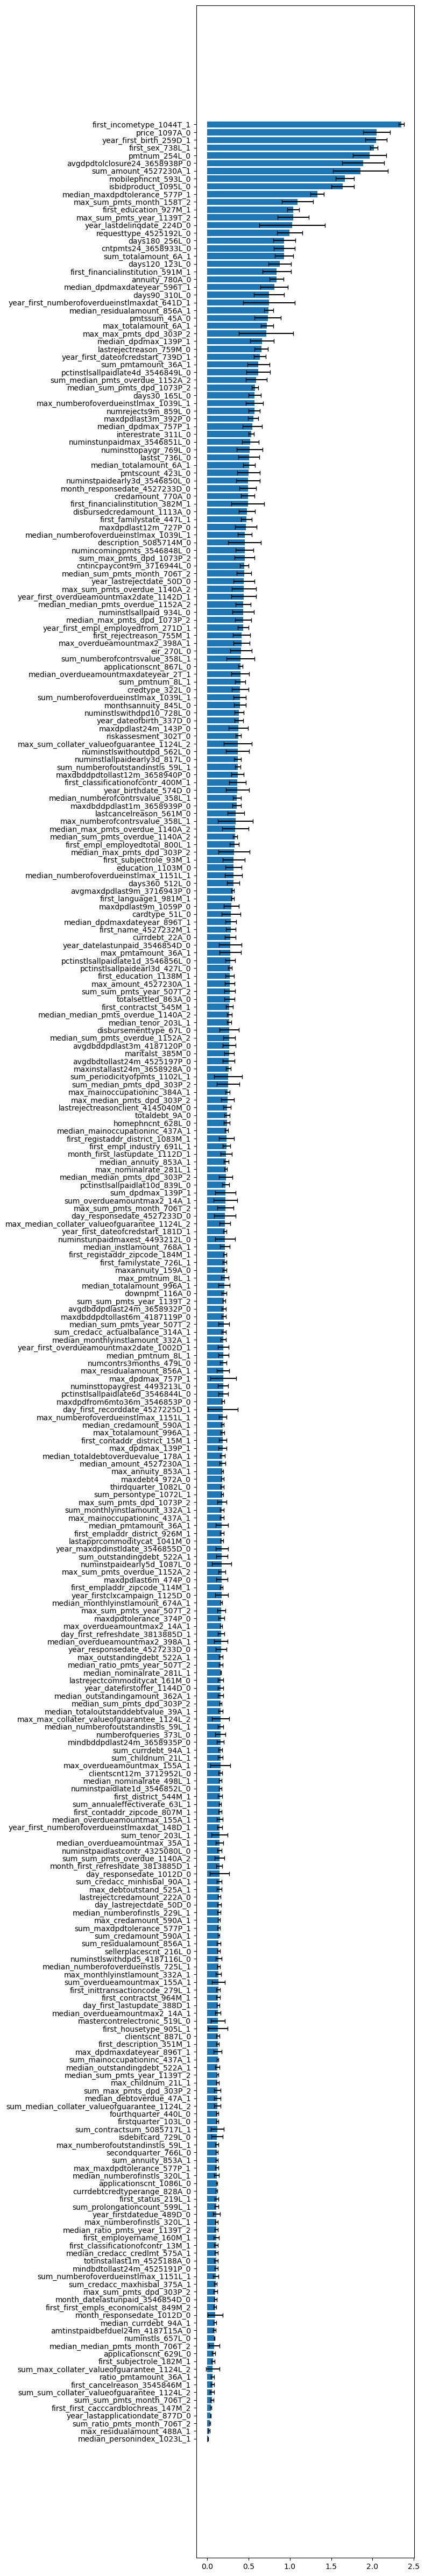

In [29]:
fimps.sort_values('fimp_mean', inplace=True)
display(fimps)

_, ax = plt.subplots(figsize=(8, 16*(len(fimps)//100)))
ax.barh(y=fimps['processed_Variable'], width=fimps['fimp_mean'], xerr=fimps['fimp_std'], capsize=3)
plt.tight_layout()
plt.show()

In [30]:
fimp_q50 = fimps['fimp_mean'].quantile(0.75)
print(fimp_q50)

fimps['smaller_than_q50'] = fimps['fimp_mean'] < fimp_q50
display(fimps)
display(fimps['smaller_than_q50'].sum())

0.39351894384948755


processed_Variable  fold_1_fimp  fold_2_fimp  \
0              median_personindex_1023L_1     0.006243     0.008371   
1               max_residualamount_488A_1     0.016874     0.038283   
2             sum_ratio_pmts_month_706T_2     0.028348     0.033038   
3         year_lastapplicationdate_877D_0     0.041478     0.042233   
4    first_first_cacccardblochreas_147M_2     0.047713     0.035007   
..                                    ...          ...          ...   
295                         pmtnum_254L_0     2.027380     2.000556   
296                      first_sex_738L_1     1.986439     2.088416   
297               year_first_birth_259D_1     1.814685     2.146729   
298                         price_1097A_0     2.090621     2.346714   
299              first_incometype_1044T_1     2.373700     2.295061   

     fold_3_fimp  fold_4_fimp  fold_5_fimp  fimp_mean  fimp_std  \
0       0.017491     0.009391     0.006134   0.009526  0.004173   
1       0.015361     0.029374     0.016138   0.023206  0.009132   
2       0.036308     0.021456     0.031899   0.030210  0.005062   
3       0.030510     0.039590     0.043192   0.039401  0.004600   
4       0.049492     0.054861     0.044474   0.046309  0.006578   
..           ...          ...          ...        ...       ...   
295     2.162102     1.577300     2.055565   1.964581  0.201254   
296     1.980769     2.044951     1.972626   2.014640  0.044876   
297     2.153961     1.993088     2.114035   2.044500  0.128628   
298     1.964416     1.988609     1.864001   2.050872  0.164545   
299     2.333860     2.386170     2.362060   2.350170  0.032540   

                     Variable  \
0           personindex_1023L   
1         residualamount_488A   
2             pmts_month_706T   
3    lastapplicationdate_877D   
4      cacccardblochreas_147M   
..                        ...   
295               pmtnum_254L   
296                  sex_738L   
297                birth_259D   
298               price_1097A   
299          incometype_1044T   

                                                                                        Description  \
0                                            Order of the person specified on the application form.   
1                                                             Residual amount of a closed contract.   
2    Month of payment for active contract (num_group1 - terminated contract, num_group2 - payment).   
3                                                          Date of previous customer's application.   
4                                                                             Card blocking reason.   
..                                                                                              ...   
295                                               Total number of loan payments made by the client.   
296                                                                           Gender of the client.   
297                                                                    Date of birth of the person.   
298                                                                                   Credit price.   
299                                                                    Type of income of the person   

    transform depth  smaller_than_q50  
0           L     1              True  
1           A     1              True  
2           T     2              True  
3           D     0              True  
4           M     2              True  
..        ...   ...               ...  
295         L     0             False  
296         L     1             False  
297         D     1             False  
298         A     0             False  
299         T     1             False  

[300 rows x 13 columns]

225

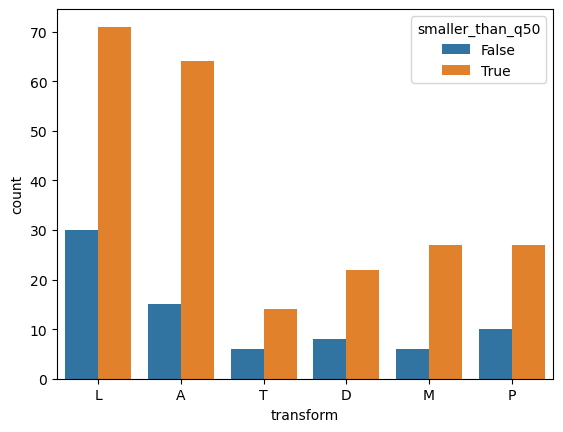

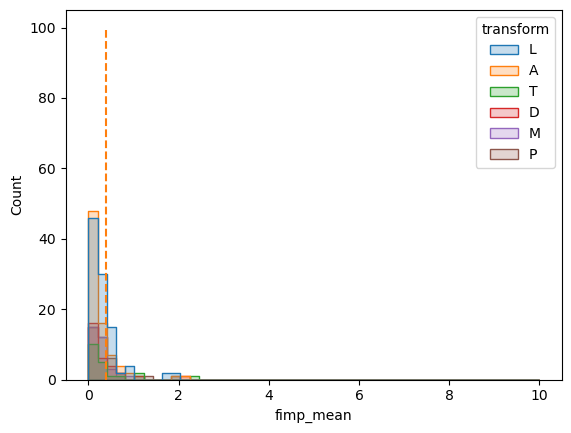

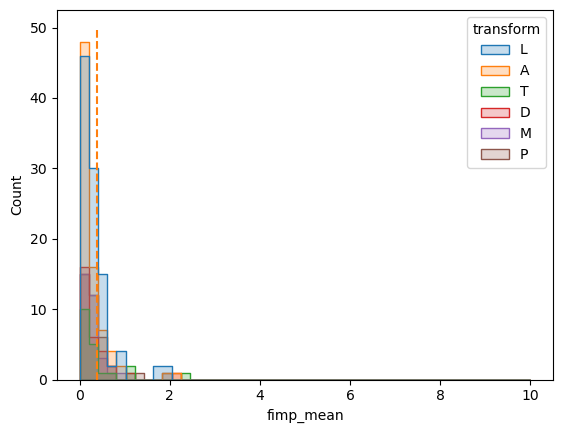

In [31]:
sns.countplot(data=fimps, x='transform', hue='smaller_than_q50')
plt.show()

_, ax = plt.subplots()
bins = np.linspace(0, 10, 50)
sns.histplot(data=fimps, x='fimp_mean', hue='transform', element='step', bins=bins, ax=ax)
ax.vlines(fimp_q50, ymin=0, ymax=100, color='tab:orange', linestyles='dashed')
plt.show()

_, ax = plt.subplots()
bins = np.linspace(0, 10, 50)
sns.histplot(data=fimps, x='fimp_mean', hue='transform', element='step', bins=bins, ax=ax)
ax.vlines(fimp_q50, ymin=0, ymax=50, color='tab:orange', linestyles='dashed')
plt.show()

### load train data

In [32]:
train_depth_paths = get_depth_paths(paths.parquet_files_dir, 'train')
print(f'number of test paths: {sum(len(v1) for v1 in train_depth_paths.values())}')

train_base_data = pl.read_parquet(
    paths.parquet_files_dir.joinpath('train/train_base.parquet')
)
train_base_data = train_base_data.cast(
    {
        'case_id': pl.Int64,
        'date_decision': pl.String,
        'MONTH': pl.Int64,
        'WEEK_NUM': pl.Int64,
        'target': pl.Int64,
    }
)
display(train_base_data)

number of test paths: 31


shape: (1_526_659, 5)
┌─────────┬───────────────┬────────┬──────────┬────────┐
│ case_id ┆ date_decision ┆ MONTH  ┆ WEEK_NUM ┆ target │
│ ---     ┆ ---           ┆ ---    ┆ ---      ┆ ---    │
│ i64     ┆ str           ┆ i64    ┆ i64      ┆ i64    │
╞═════════╪═══════════════╪════════╪══════════╪════════╡
│ 0       ┆ 2019-01-03    ┆ 201901 ┆ 0        ┆ 0      │
│ 1       ┆ 2019-01-03    ┆ 201901 ┆ 0        ┆ 0      │
│ 2       ┆ 2019-01-04    ┆ 201901 ┆ 0        ┆ 0      │
│ 3       ┆ 2019-01-03    ┆ 201901 ┆ 0        ┆ 0      │
│ 4       ┆ 2019-01-04    ┆ 201901 ┆ 0        ┆ 1      │
│ …       ┆ …             ┆ …      ┆ …        ┆ …      │
│ 2703450 ┆ 2020-10-05    ┆ 202010 ┆ 91       ┆ 0      │
│ 2703451 ┆ 2020-10-05    ┆ 202010 ┆ 91       ┆ 0      │
│ 2703452 ┆ 2020-10-05    ┆ 202010 ┆ 91       ┆ 0      │
│ 2703453 ┆ 2020-10-05    ┆ 202010 ┆ 91       ┆ 0      │
│ 2703454 ┆ 2020-10-05    ┆ 202010 ┆ 91       ┆ 0      │
└─────────┴───────────────┴────────┴──────────┴────────┘

In [33]:
%%time


depth_data = merge_dataset(
    train_base_data,
    train_depth_paths,
    bool_features,
    float64_features,
    string_features,
    date_features,
    None,
    '012'
)
display(depth_data)
display(depth_data.dtypes.value_counts())

loading `static_0`
	(1003757, 168)
	(522902, 168)
loading `static_cb_0`
	(1500476, 53)
loading `applprev_1`
	(782997, 92)
	(438525, 92)
loading `other_1`
	(51109, 21)
loading `tax_registry_a_1`
	(457934, 7)
loading `tax_registry_b_1`
	(150732, 7)
loading `tax_registry_c_1`
	(482265, 7)
loading `credit_bureau_a_1`
	(335275, 240)
	(549263, 240)
	(325127, 240)
	(176608, 240)
loading `credit_bureau_b_1`
	(36500, 134)
loading `deposit_1`
	(105111, 7)
loading `person_1`
	(1526659, 46)
loading `debitcard_1`
	(111772, 14)
loading `applprev_2`
	(1221522, 4)
loading `person_2`
	(1435105, 9)
loading `credit_bureau_a_2`
	(98303, 127)
	(118481, 127)
	(23734, 127)
	(156749, 127)
	(190486, 127)
	(190313, 127)
	(231250, 127)
	(150426, 127)
	(45056, 127)
	(77457, 127)
	(103033, 127)
loading `credit_bureau_b_2`
	(36447, 26)


case_id date_decision   MONTH  WEEK_NUM  target  \
0              0    2019-01-03  201901         0       0   
1              1    2019-01-03  201901         0       0   
2              2    2019-01-04  201901         0       0   
3              3    2019-01-03  201901         0       0   
4              4    2019-01-04  201901         0       1   
...          ...           ...     ...       ...     ...   
1526654  2703450    2020-10-05  202010        91       0   
1526655  2703451    2020-10-05  202010        91       0   
1526656  2703452    2020-10-05  202010        91       0   
1526657  2703453    2020-10-05  202010        91       0   
1526658  2703454    2020-10-05  202010        91       0   

         actualdpdtolerance_344P_0  amtinstpaidbefduel24m_4187115A_0  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              NaN                               NaN   
4                              NaN                               NaN   
...                            ...                               ...   
1526654                        0.0                     176561.359375   
1526655                        0.0                     301276.468750   
1526656                        0.0                      14232.400391   
1526657                        0.0                     197371.578125   
1526658                        0.0                      82949.601562   

         annuity_780A_0  annuitynextmonth_57A_0  applicationcnt_361L_0  ...  \
0           1917.599976                0.000000                    0.0  ...   
1           3134.000000                0.000000                    0.0  ...   
2           4937.000000                0.000000                    0.0  ...   
3           4643.600098                0.000000                    0.0  ...   
4           3390.199951                0.000000                    0.0  ...   
...                 ...                     ...                    ...  ...   
1526654     3675.400146                0.000000                    0.0  ...   
1526655     7088.600098             6191.600098                    0.0  ...   
1526656     7788.800293                0.000000                    0.0  ...   
1526657     1195.400024             2827.199951                    0.0  ...   
1526658     4533.800293             2986.800049                    0.0  ...   

         day_first_contractmaturitydate_151D_1  day_first_lastupdate_260D_1  \
0                                          NaN                          NaN   
1                                          NaN                          NaN   
2                                          NaN                          NaN   
3                                          NaN                          NaN   
4                                          NaN                          NaN   
...                                        ...                          ...   
1526654                                    NaN                          NaN   
1526655                                    NaN                          NaN   
1526656                                    NaN                          NaN   
1526657                                    NaN                          NaN   
1526658                                    NaN                          NaN   

         day_first_contractenddate_991D_1  day_first_openingdate_313D_1  \
0                                     NaN                           NaN   
1                                     NaN                           NaN   
2                                     NaN                           NaN   
3                                     NaN                           NaN   
4                                     NaN                           NaN   
...                                   ...                           ...   


float32    955
object     100
int8         6
int64        4
Name: count, dtype: int64

CPU times: user 16min 22s, sys: 48.8 s, total: 17min 11s
Wall time: 1min 12s


In [34]:
nans = (depth_data.isna().sum() / len(depth_data)).reset_index()
nans.columns = ['processed_Variable', 'ratio_nan']

display(fimps)
display(nans)

fimps = fimps.merge(nans, on='processed_Variable', how='left')
display(fimps)

processed_Variable  fold_1_fimp  fold_2_fimp  \
0              median_personindex_1023L_1     0.006243     0.008371   
1               max_residualamount_488A_1     0.016874     0.038283   
2             sum_ratio_pmts_month_706T_2     0.028348     0.033038   
3         year_lastapplicationdate_877D_0     0.041478     0.042233   
4    first_first_cacccardblochreas_147M_2     0.047713     0.035007   
..                                    ...          ...          ...   
295                         pmtnum_254L_0     2.027380     2.000556   
296                      first_sex_738L_1     1.986439     2.088416   
297               year_first_birth_259D_1     1.814685     2.146729   
298                         price_1097A_0     2.090621     2.346714   
299              first_incometype_1044T_1     2.373700     2.295061   

     fold_3_fimp  fold_4_fimp  fold_5_fimp  fimp_mean  fimp_std  \
0       0.017491     0.009391     0.006134   0.009526  0.004173   
1       0.015361     0.029374     0.016138   0.023206  0.009132   
2       0.036308     0.021456     0.031899   0.030210  0.005062   
3       0.030510     0.039590     0.043192   0.039401  0.004600   
4       0.049492     0.054861     0.044474   0.046309  0.006578   
..           ...          ...          ...        ...       ...   
295     2.162102     1.577300     2.055565   1.964581  0.201254   
296     1.980769     2.044951     1.972626   2.014640  0.044876   
297     2.153961     1.993088     2.114035   2.044500  0.128628   
298     1.964416     1.988609     1.864001   2.050872  0.164545   
299     2.333860     2.386170     2.362060   2.350170  0.032540   

                     Variable  \
0           personindex_1023L   
1         residualamount_488A   
2             pmts_month_706T   
3    lastapplicationdate_877D   
4      cacccardblochreas_147M   
..                        ...   
295               pmtnum_254L   
296                  sex_738L   
297                birth_259D   
298               price_1097A   
299          incometype_1044T   

                                                                                        Description  \
0                                            Order of the person specified on the application form.   
1                                                             Residual amount of a closed contract.   
2    Month of payment for active contract (num_group1 - terminated contract, num_group2 - payment).   
3                                                          Date of previous customer's application.   
4                                                                             Card blocking reason.   
..                                                                                              ...   
295                                               Total number of loan payments made by the client.   
296                                                                           Gender of the client.   
297                                                                    Date of birth of the person.   
298                                                                                   Credit price.   
299                                                                    Type of income of the person   

    transform depth  smaller_than_q50  
0           L     1              True  
1           A     1              True  
2           T     2              True  
3           D     0              True  
4           M     2              True  
..        ...   ...               ...  
295         L     0             False  
296         L     1             False  
297         D     1             False  
298         A     0             False  
299         T     1             False  

[300 rows x 13 columns]

processed_Variable  ratio_nan
0                                       case_id   0.000000
1                                 date_decision   0.000000
2                                         MONTH   0.000000
3                                      WEEK_NUM   0.000000
4                                        target   0.000000
...                                         ...        ...
1060                  day_first_birthdate_87D_1   0.991840
1061         day_first_empl_employedfrom_271D_1   0.628797
1062               day_first_openingdate_857D_1   0.932508
1063  day_first_first_empls_employedfrom_796D_2   0.998151
1064          day_first_first_pmts_date_1107D_2   0.976126

[1065 rows x 2 columns]

processed_Variable  fold_1_fimp  fold_2_fimp  \
0              median_personindex_1023L_1     0.006243     0.008371   
1               max_residualamount_488A_1     0.016874     0.038283   
2             sum_ratio_pmts_month_706T_2     0.028348     0.033038   
3         year_lastapplicationdate_877D_0     0.041478     0.042233   
4    first_first_cacccardblochreas_147M_2     0.047713     0.035007   
..                                    ...          ...          ...   
295                         pmtnum_254L_0     2.027380     2.000556   
296                      first_sex_738L_1     1.986439     2.088416   
297               year_first_birth_259D_1     1.814685     2.146729   
298                         price_1097A_0     2.090621     2.346714   
299              first_incometype_1044T_1     2.373700     2.295061   

     fold_3_fimp  fold_4_fimp  fold_5_fimp  fimp_mean  fimp_std  \
0       0.017491     0.009391     0.006134   0.009526  0.004173   
1       0.015361     0.029374     0.016138   0.023206  0.009132   
2       0.036308     0.021456     0.031899   0.030210  0.005062   
3       0.030510     0.039590     0.043192   0.039401  0.004600   
4       0.049492     0.054861     0.044474   0.046309  0.006578   
..           ...          ...          ...        ...       ...   
295     2.162102     1.577300     2.055565   1.964581  0.201254   
296     1.980769     2.044951     1.972626   2.014640  0.044876   
297     2.153961     1.993088     2.114035   2.044500  0.128628   
298     1.964416     1.988609     1.864001   2.050872  0.164545   
299     2.333860     2.386170     2.362060   2.350170  0.032540   

                     Variable  \
0           personindex_1023L   
1         residualamount_488A   
2             pmts_month_706T   
3    lastapplicationdate_877D   
4      cacccardblochreas_147M   
..                        ...   
295               pmtnum_254L   
296                  sex_738L   
297                birth_259D   
298               price_1097A   
299          incometype_1044T   

                                                                                        Description  \
0                                            Order of the person specified on the application form.   
1                                                             Residual amount of a closed contract.   
2    Month of payment for active contract (num_group1 - terminated contract, num_group2 - payment).   
3                                                          Date of previous customer's application.   
4                                                                             Card blocking reason.   
..                                                                                              ...   
295                                               Total number of loan payments made by the client.   
296                                                                           Gender of the client.   
297                                                                    Date of birth of the person.   
298                                                                                   Credit price.   
299                                                                    Type of income of the person   

    transform depth  smaller_than_q50  ratio_nan  
0           L     1              True   0.000000  
1           A     1              True   0.680962  
2           T     2              True   0.092602  
3           D     0              True   0.199872  
4           M     2              True   0.199872  
..        ...   ...               ...        ...  
295         L     0             False   0.029446  
296         L     1             False   0.000000  
297         D     1             False   0.000000  
298         A     0             False   0.146228  
299         T     1             False   0.000000  

[300 rows x 14 columns]

#### plot feature importance per transform type

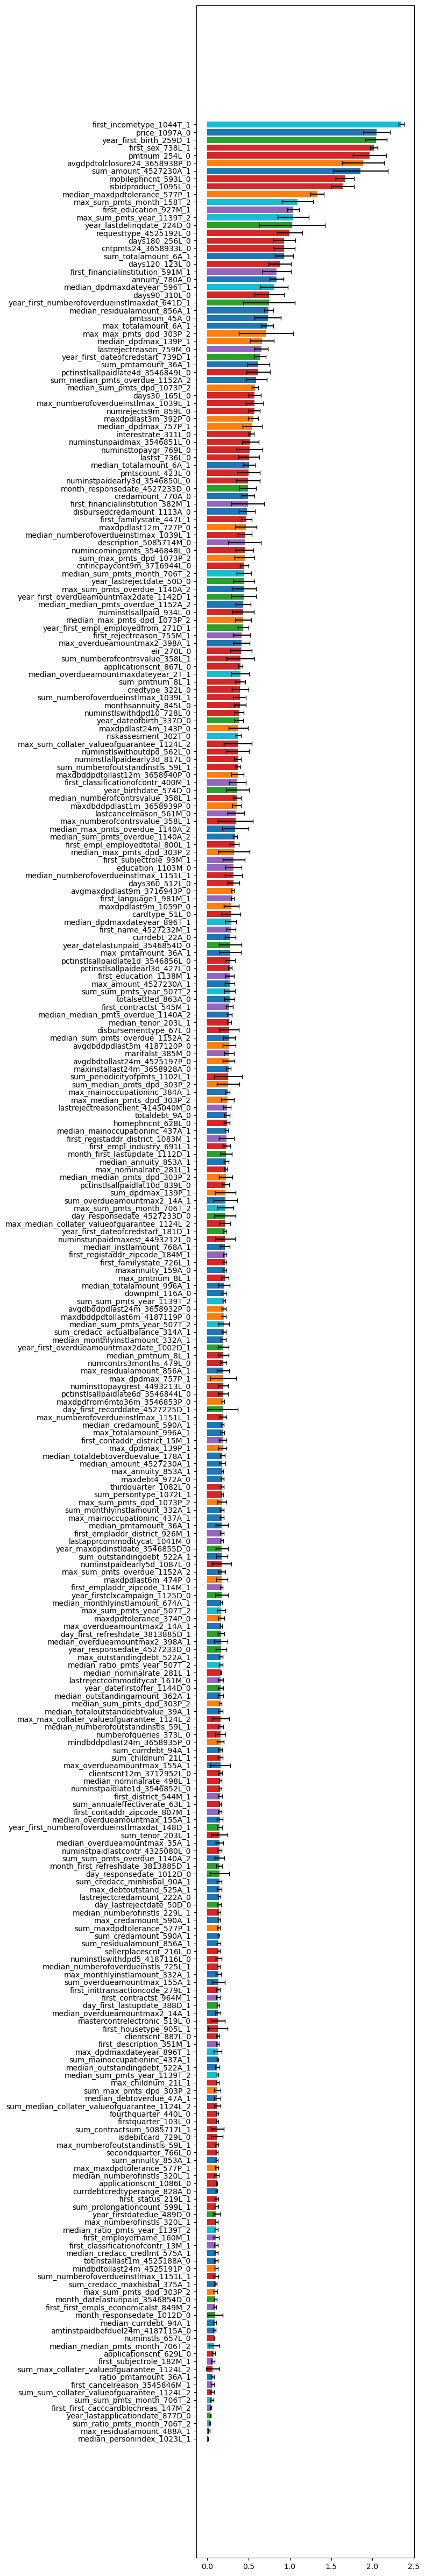

In [35]:
colors = np.array(['tab:orange'] * len(fimps))
colors[fimps['transform']=='A'] = 'tab:blue'
colors[fimps['transform']=='D'] = 'tab:green'
colors[fimps['transform']=='L'] = 'tab:red'
colors[fimps['transform']=='M'] = 'tab:purple'
colors[fimps['transform']=='T'] = 'tab:cyan'

_, ax = plt.subplots(figsize=(8, 16*len(fimps)//100))
ax.barh(
    y=fimps['processed_Variable'],
    width=fimps['fimp_mean'],
    xerr=fimps['fimp_std'],
    capsize=3,
    color=colors,
)
plt.tight_layout()
#plt.xscale('log')
plt.show()

#### plot feature importance per depth

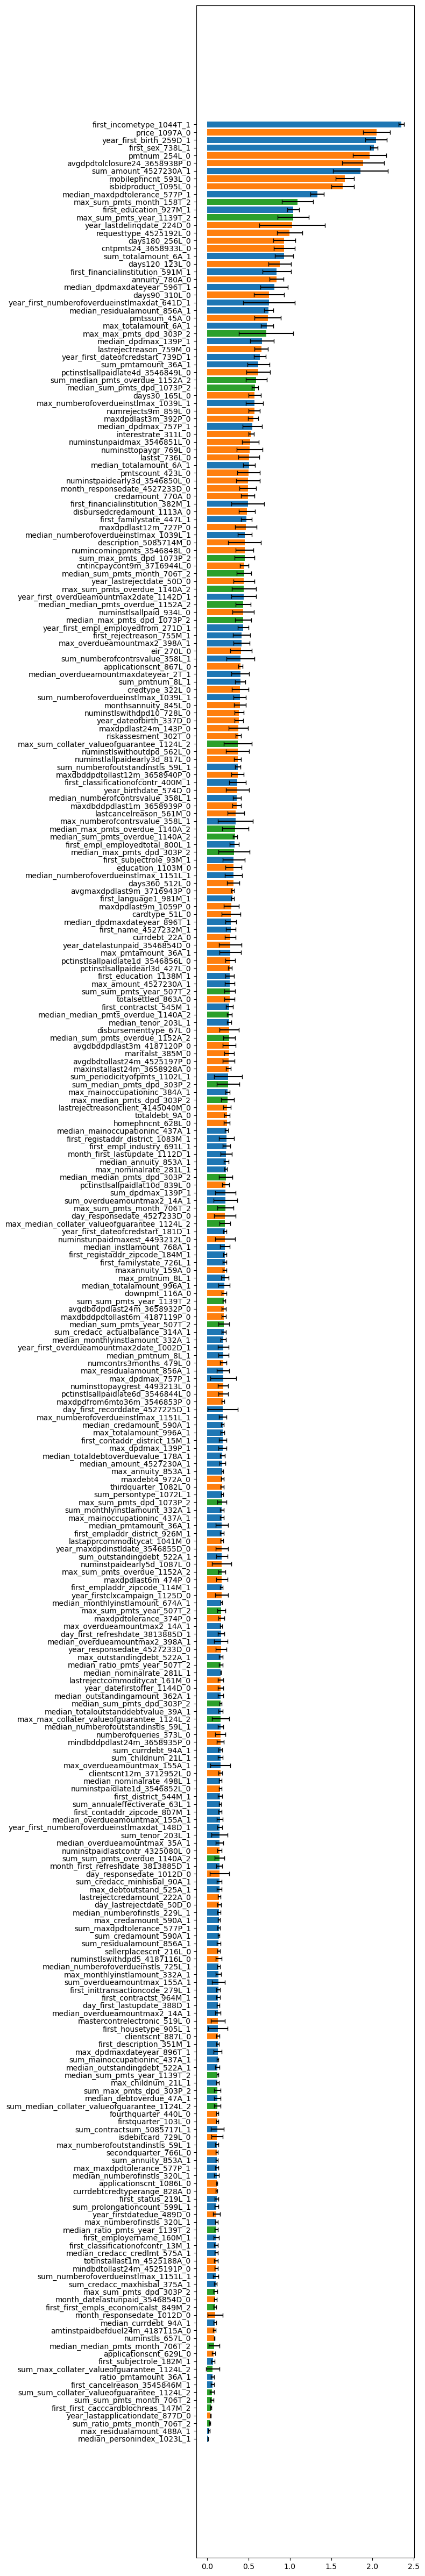

In [36]:
colors = np.array(['tab:orange'] * len(fimps))
colors[fimps['depth']=='1'] = 'tab:blue'
colors[fimps['depth']=='2'] = 'tab:green'

_, ax = plt.subplots(figsize=(8, 16*len(fimps)//100))
ax.barh(
    y=fimps['processed_Variable'],
    width=fimps['fimp_mean'],
    xerr=fimps['fimp_std'],
    capsize=3,
    color=colors,
)
plt.tight_layout()
#plt.xscale('log')
plt.show()

#### plot feature importance per number of nan

processed_Variable  fold_1_fimp  fold_2_fimp  \
0              median_personindex_1023L_1     0.006243     0.008371   
1               max_residualamount_488A_1     0.016874     0.038283   
2             sum_ratio_pmts_month_706T_2     0.028348     0.033038   
3         year_lastapplicationdate_877D_0     0.041478     0.042233   
4    first_first_cacccardblochreas_147M_2     0.047713     0.035007   
..                                    ...          ...          ...   
295                         pmtnum_254L_0     2.027380     2.000556   
296                      first_sex_738L_1     1.986439     2.088416   
297               year_first_birth_259D_1     1.814685     2.146729   
298                         price_1097A_0     2.090621     2.346714   
299              first_incometype_1044T_1     2.373700     2.295061   

     fold_3_fimp  fold_4_fimp  fold_5_fimp  fimp_mean  fimp_std  \
0       0.017491     0.009391     0.006134   0.009526  0.004173   
1       0.015361     0.029374     0.016138   0.023206  0.009132   
2       0.036308     0.021456     0.031899   0.030210  0.005062   
3       0.030510     0.039590     0.043192   0.039401  0.004600   
4       0.049492     0.054861     0.044474   0.046309  0.006578   
..           ...          ...          ...        ...       ...   
295     2.162102     1.577300     2.055565   1.964581  0.201254   
296     1.980769     2.044951     1.972626   2.014640  0.044876   
297     2.153961     1.993088     2.114035   2.044500  0.128628   
298     1.964416     1.988609     1.864001   2.050872  0.164545   
299     2.333860     2.386170     2.362060   2.350170  0.032540   

                     Variable  \
0           personindex_1023L   
1         residualamount_488A   
2             pmts_month_706T   
3    lastapplicationdate_877D   
4      cacccardblochreas_147M   
..                        ...   
295               pmtnum_254L   
296                  sex_738L   
297                birth_259D   
298               price_1097A   
299          incometype_1044T   

                                                                                        Description  \
0                                            Order of the person specified on the application form.   
1                                                             Residual amount of a closed contract.   
2    Month of payment for active contract (num_group1 - terminated contract, num_group2 - payment).   
3                                                          Date of previous customer's application.   
4                                                                             Card blocking reason.   
..                                                                                              ...   
295                                               Total number of loan payments made by the client.   
296                                                                           Gender of the client.   
297                                                                    Date of birth of the person.   
298                                                                                   Credit price.   
299                                                                    Type of income of the person   

    transform depth  smaller_than_q50  ratio_nan  
0           L     1              True   0.000000  
1           A     1              True   0.680962  
2           T     2              True   0.092602  
3           D     0              True   0.199872  
4           M     2              True   0.199872  
..        ...   ...               ...        ...  
295         L     0             False   0.029446  
296         L     1             False   0.000000  
297         D     1             False   0.000000  
298         A     0             False   0.146228  
299         T     1             False   0.000000  

[300 rows x 14 columns]

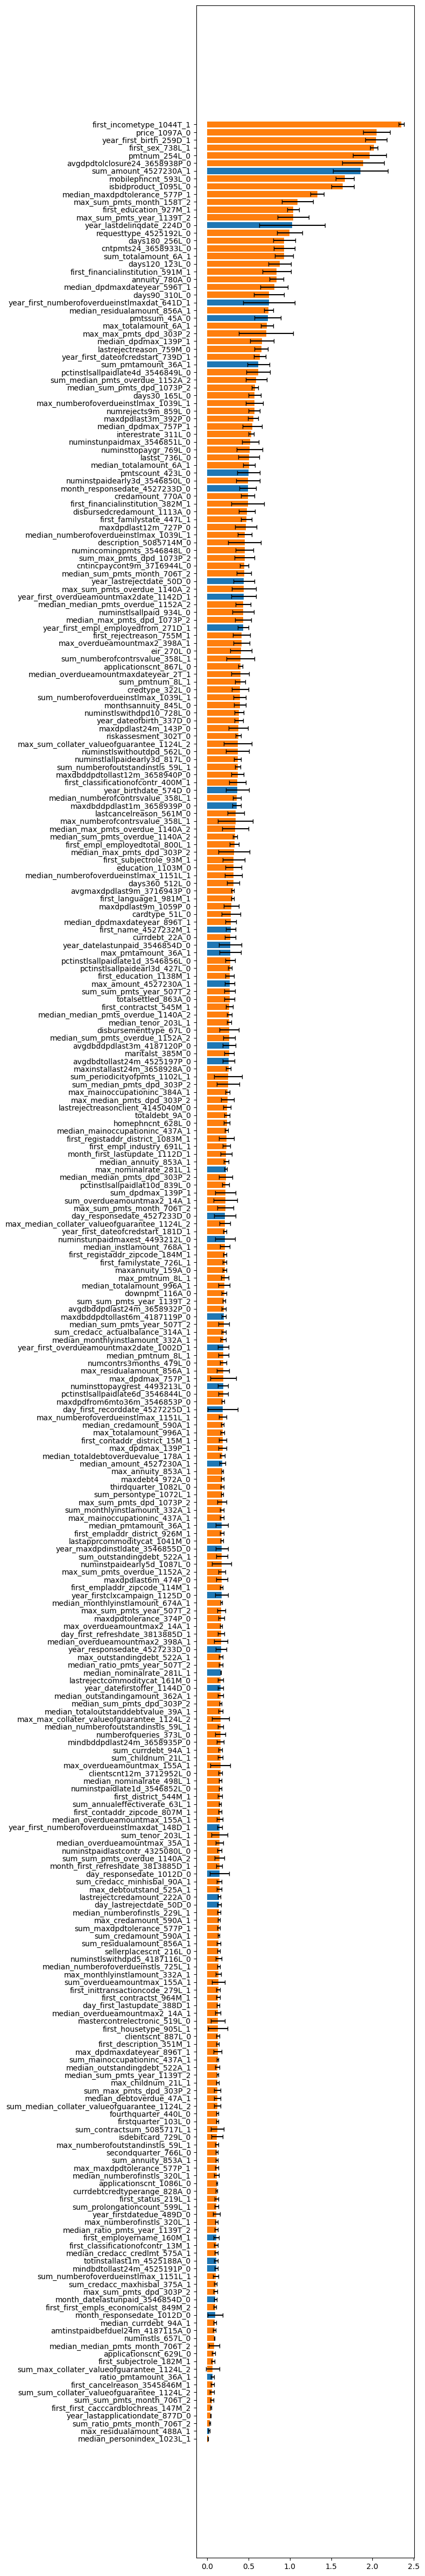

In [37]:
display(fimps)

colors = np.array(['tab:orange'] * len(fimps))
colors[fimps['ratio_nan'] > 0.5] = 'tab:blue'

_, ax = plt.subplots(figsize=(8, 16*len(fimps)//100))
ax.barh(
    y=fimps['processed_Variable'],
    width=fimps['fimp_mean'],
    xerr=fimps['fimp_std'],
    capsize=3,
    color=colors,
)
plt.tight_layout()
#plt.xscale('log')
plt.show()

#### plot feature importance per number of nan

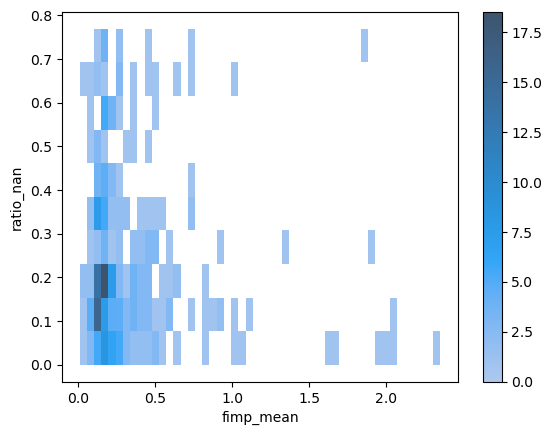

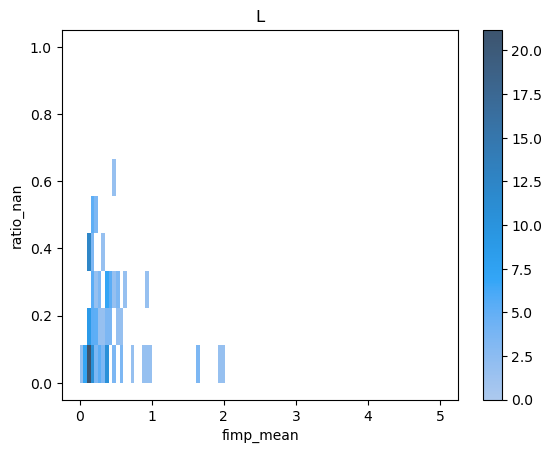

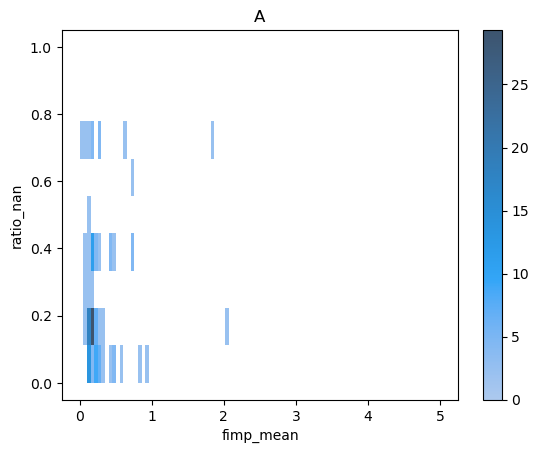

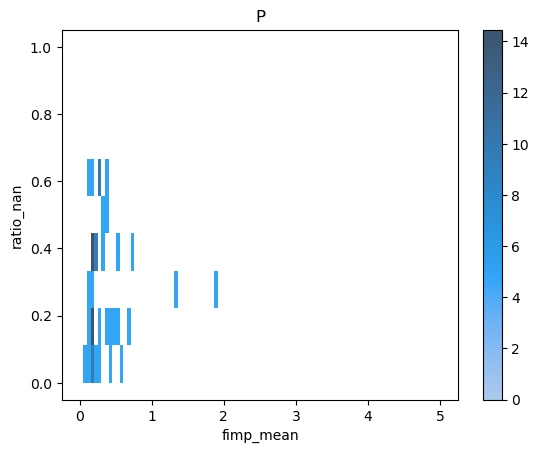

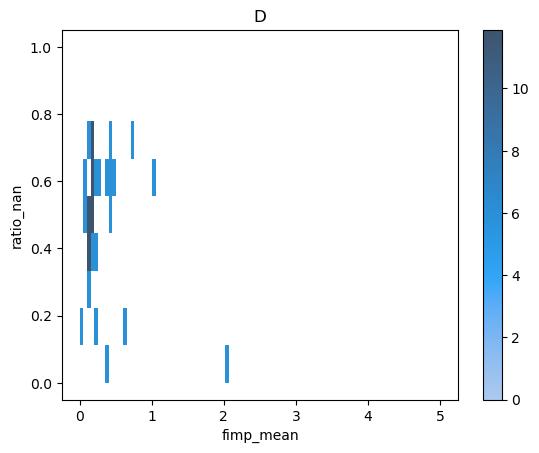

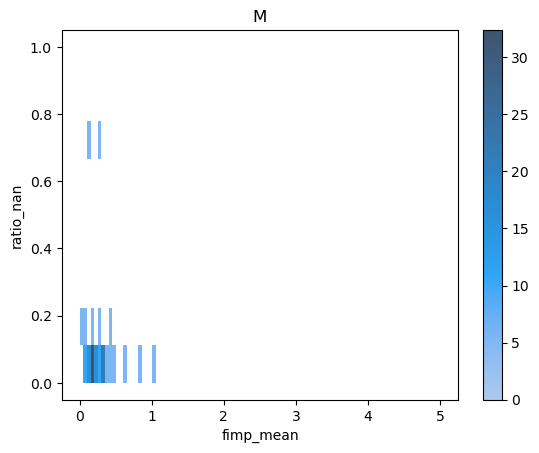

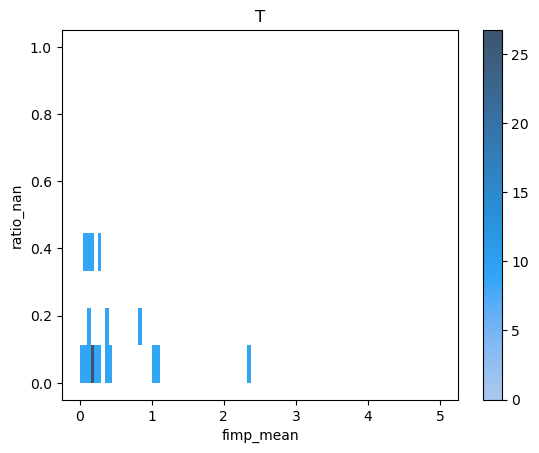

In [38]:
sns.histplot(
    data=fimps,
    x='fimp_mean',
    y='ratio_nan',
    bins=(50, 10),
    stat='density',
    cbar=True,
)
plt.show()


for t in ['L', 'A', 'P', 'D', 'M', 'T']:
    ax = sns.histplot(
        data=fimps.query('transform==@t'),
        x='fimp_mean',
        y='ratio_nan',
        bins=(np.linspace(0, 5, 100), np.linspace(0, 1, 10)),
        stat='density',
        cbar=True,
    )
    ax.set_title(t)
    plt.show()

#### plot M features

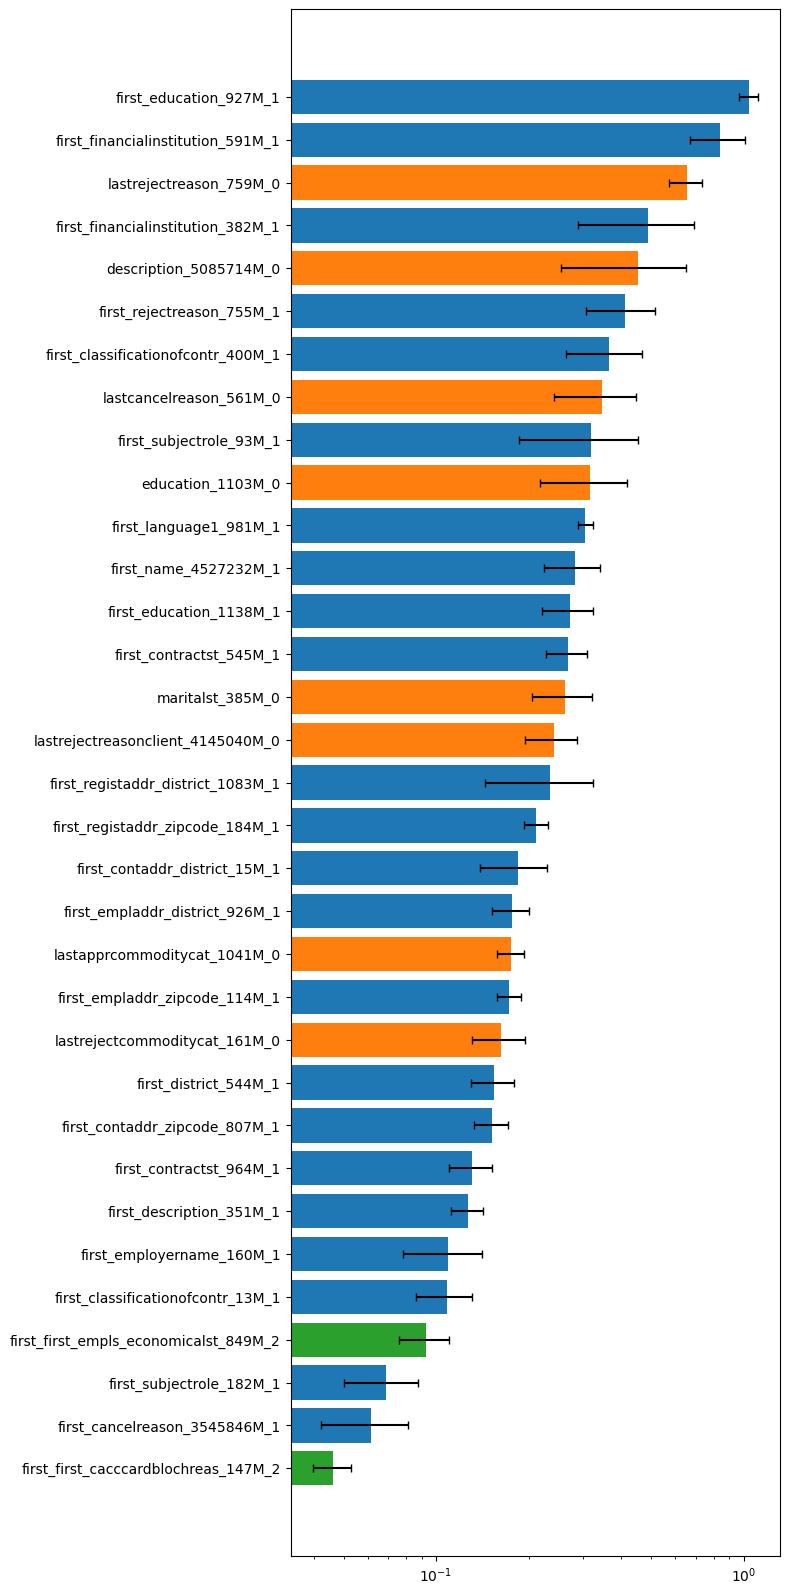

In [39]:
colors = np.array(['tab:orange'] * len(fimps.query('transform=="M"')))
colors[fimps.query('transform=="M"')['processed_Variable'].str.endswith('1')] = 'tab:blue'
colors[fimps.query('transform=="M"')['processed_Variable'].str.endswith('2')] = 'tab:green'

_, ax = plt.subplots(figsize=(8, 16))
ax.barh(
    y=fimps.query('transform=="M"')['processed_Variable'],
    width=fimps.query('transform=="M"')['fimp_mean'],
    xerr=fimps.query('transform=="M"')['fimp_std'],
    capsize=3,
    color=colors,
)
plt.tight_layout()
plt.xscale('log')
plt.show()

#### plot top k features

processed_Variable  fimp_mean  \
0                       first_incometype_1044T_1   2.350170   
1                                  price_1097A_0   2.050872   
2                        year_first_birth_259D_1   2.044500   
3                               first_sex_738L_1   2.014640   
4                                  pmtnum_254L_0   1.964581   
5                  avgdpdtolclosure24_3658938P_0   1.886528   
6                          sum_amount_4527230A_1   1.852541   
7                            mobilephncnt_593L_0   1.666050   
8                           isbidproduct_1095L_0   1.637636   
9                  median_maxdpdtolerance_577P_1   1.330293   
10                     max_sum_pmts_month_158T_2   1.092814   
11                        first_education_927M_1   1.041404   
12                     max_sum_pmts_year_1139T_2   1.038396   
13                    year_lastdelinqdate_224D_0   1.026931   
14                        requesttype_4525192L_0   0.996364   
15                                days180_256L_0   0.932631   
16                          cntpmts24_3658933L_0   0.930989   
17                          sum_totalamount_6A_1   0.927920   
18                                days120_123L_0   0.878116   
19             first_financialinstitution_591M_1   0.839644   
20                                annuity_780A_0   0.837480   
21                  median_dpdmaxdateyear_596T_1   0.810094   
22                                 days90_310L_0   0.749122   
23  year_first_numberofoverdueinstlmaxdat_641D_1   0.747677   
24                  median_residualamount_856A_1   0.742333   
25                                 pmtssum_45A_0   0.731324   
26                          max_totalamount_6A_1   0.721996   
27                       max_max_pmts_dpd_303P_2   0.712619   
28                          median_dpdmax_139P_1   0.663211   
29                       lastrejectreason_759M_0   0.653153   
30             year_first_dateofcredstart_739D_1   0.634743   
31                           sum_pmtamount_36A_1   0.620052   
32             pctinstlsallpaidlate4d_3546849L_0   0.618004   
33               sum_median_pmts_overdue_1152A_2   0.593156   
34                   median_sum_pmts_dpd_1073P_2   0.576862   
35                                 days30_165L_0   0.574177   
36           max_numberofoverdueinstlmax_1039L_1   0.573553   
37                           numrejects9m_859L_0   0.569578   
38                           maxdpdlast3m_392P_0   0.555263   
39                          median_dpdmax_757P_1   0.548152   
40                           interestrate_311L_0   0.532612   
41                   numinstunpaidmax_3546851L_0   0.521902   
42                         numinsttopaygr_769L_0   0.513121   
43                                 lastst_736L_0   0.504448   
44                       median_totalamount_6A_1   0.504265   
45                              pmtscount_423L_0   0.499712   
46                 numinstpaidearly3d_3546850L_0   0.493799   
47                 month_responsedate_4527233D_0   0.491296   
48                             credamount_770A_0   0.491260   
49             first_financialinstitution_382M_1   0.490475   

                           Variable  \
0                  incometype_1044T   
1                       price_1097A   
2                        birth_259D   
3                          sex_738L   
4                       pmtnum_254L   
5       avgdpdtolclosure24_3658938P   
6                   amount_4527230A   
7                 mobilephncnt_593L   
8                isbidproduct_1095L   
9              maxdpdtolerance_577P   
10                  pmts_month_158T   
11                   education_927M   
12                  pmts_year_1139T   
13              lastdelinqdate_224D   
14             requesttype_4525192L   
15                     days180_256L   
16               cntpmts24_3658933L   
17                   totalamount_6A   
18                     days120_123L   
19        financialinstitution_591M 

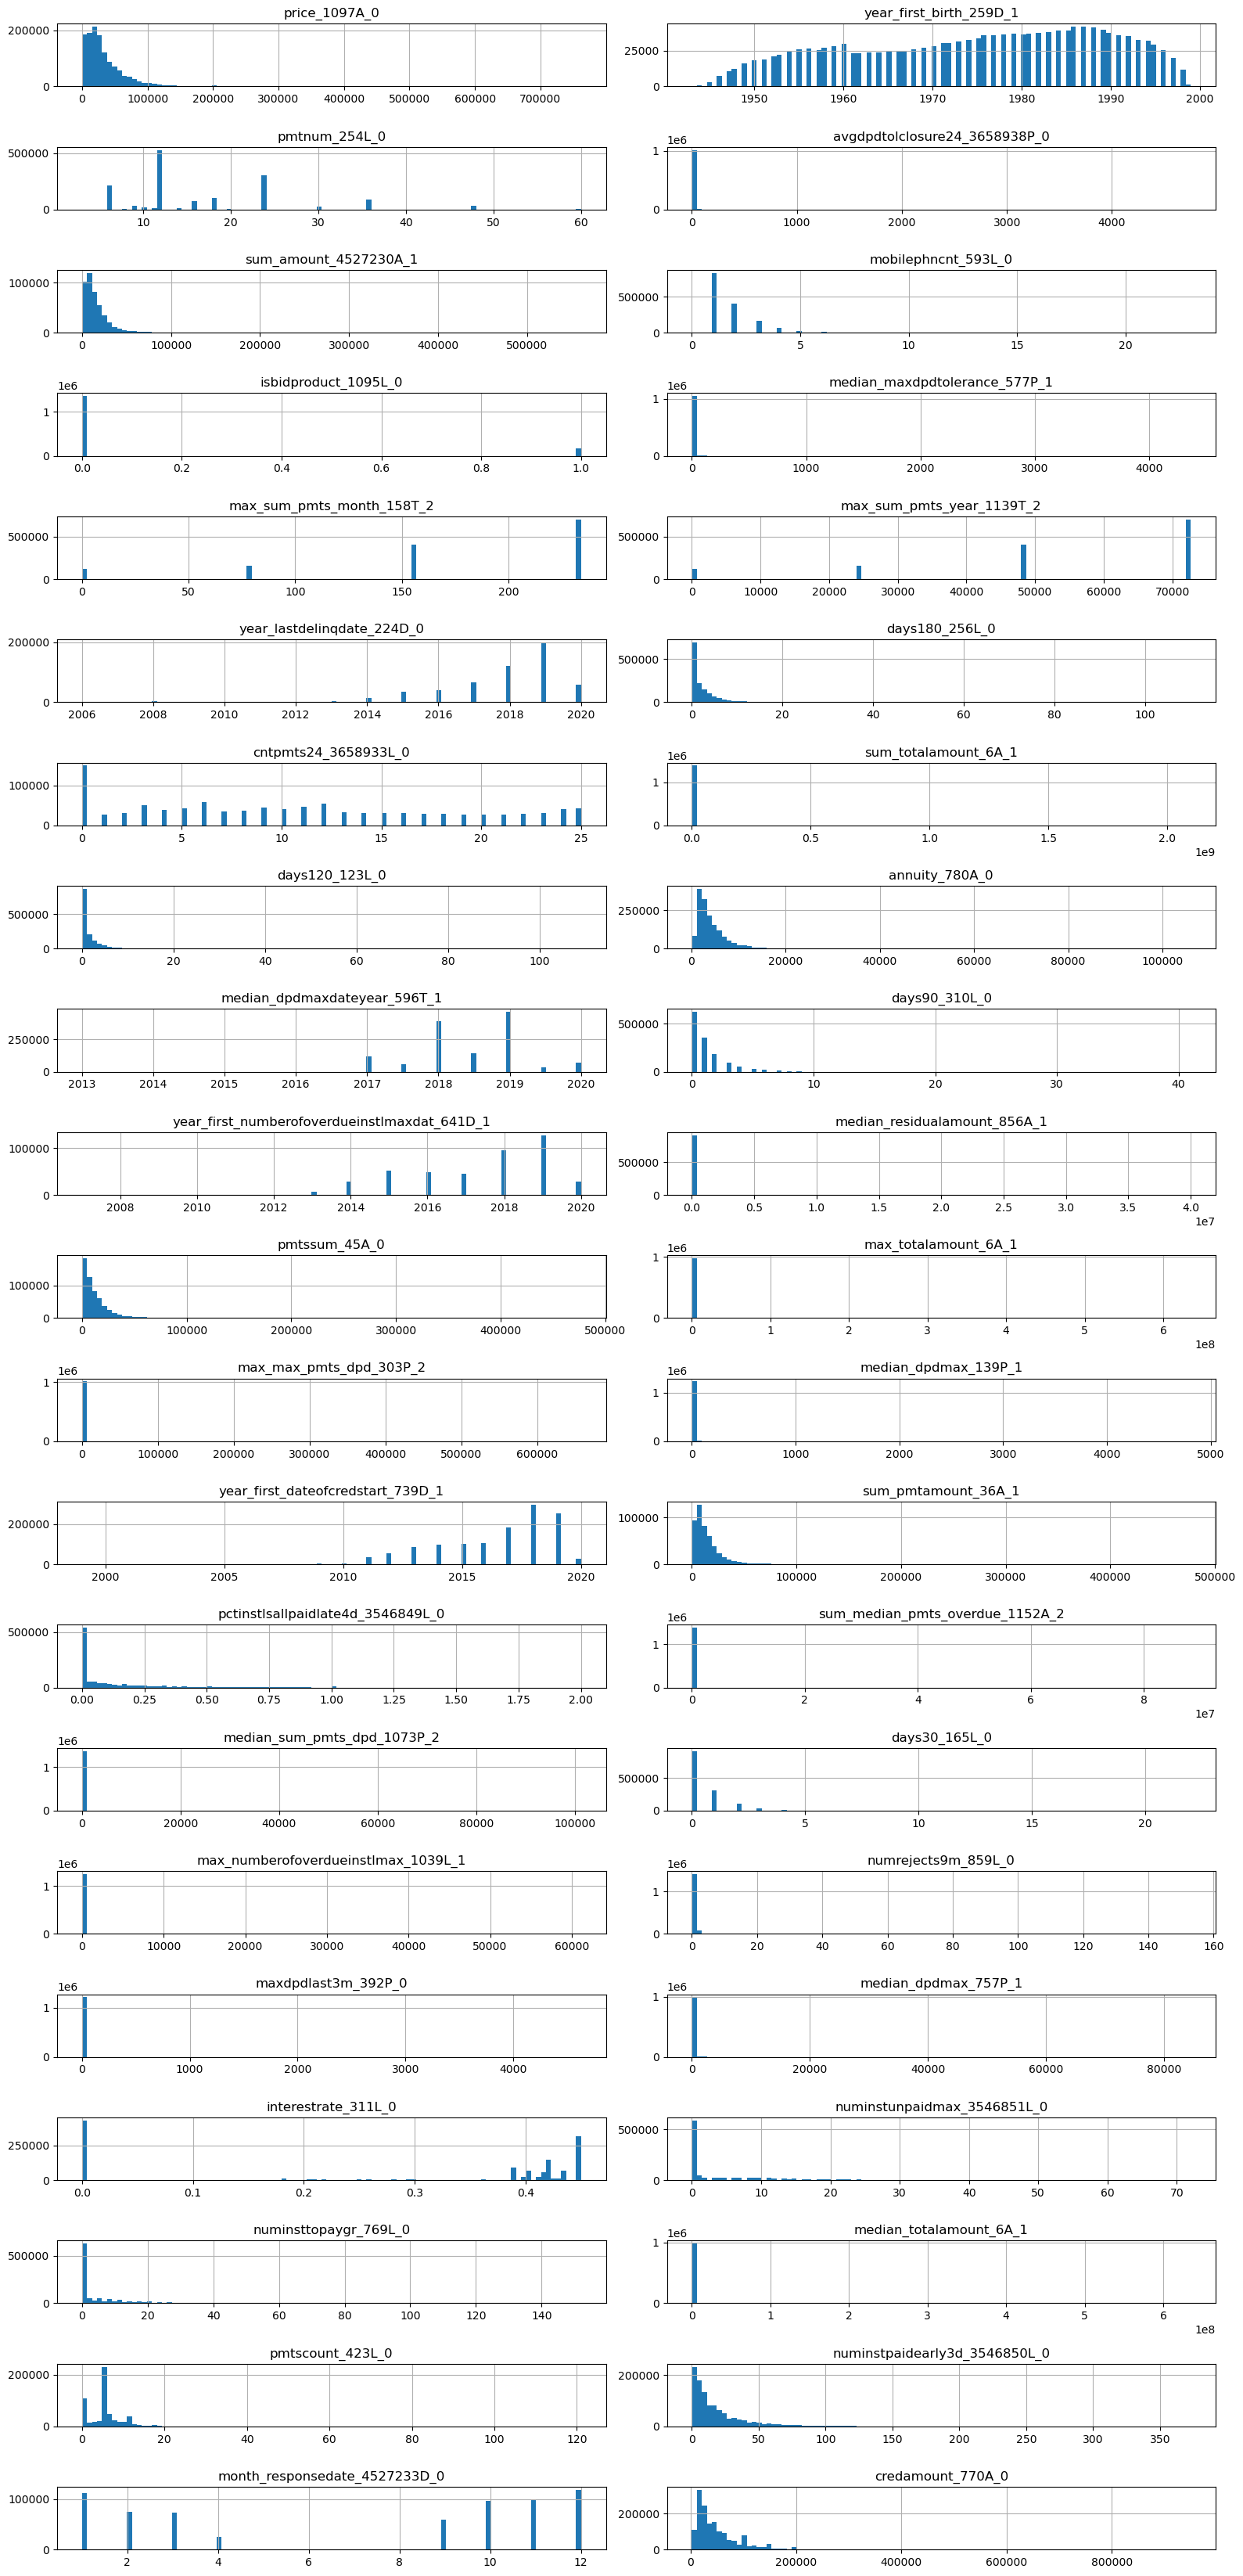

In [40]:
k = 50
topk_features = fimps.sort_values('fimp_mean', ascending=False).reset_index(drop=True).iloc[:k]
display(topk_features[['processed_Variable', 'fimp_mean', 'Variable', 'Description', 'transform', 'depth']])

_ = depth_data[topk_features['processed_Variable'].to_list()].hist(bins=100, layout=(len(topk_features)+1, 2), figsize=(16, 16*5))
plt.tight_layout()
plt.show()

processed_Variable  fimp_mean  \
1                       price_1097A_0   2.050872   
4                       pmtnum_254L_0   1.964581   
5       avgdpdtolclosure24_3658938P_0   1.886528   
7                 mobilephncnt_593L_0   1.666050   
8                isbidproduct_1095L_0   1.637636   
13         year_lastdelinqdate_224D_0   1.026931   
14             requesttype_4525192L_0   0.996364   
15                     days180_256L_0   0.932631   
16               cntpmts24_3658933L_0   0.930989   
18                     days120_123L_0   0.878116   
20                     annuity_780A_0   0.837480   
22                      days90_310L_0   0.749122   
25                      pmtssum_45A_0   0.731324   
29            lastrejectreason_759M_0   0.653153   
32  pctinstlsallpaidlate4d_3546849L_0   0.618004   
35                      days30_165L_0   0.574177   
37                numrejects9m_859L_0   0.569578   
38                maxdpdlast3m_392P_0   0.555263   
40                interestrate_311L_0   0.532612   
41        numinstunpaidmax_3546851L_0   0.521902   
42              numinsttopaygr_769L_0   0.513121   
43                      lastst_736L_0   0.504448   
45                   pmtscount_423L_0   0.499712   
46      numinstpaidearly3d_3546850L_0   0.493799   
47      month_responsedate_4527233D_0   0.491296   
48                  credamount_770A_0   0.491260   

                           Variable  \
1                       price_1097A   
4                       pmtnum_254L   
5       avgdpdtolclosure24_3658938P   
7                 mobilephncnt_593L   
8                isbidproduct_1095L   
13              lastdelinqdate_224D   
14             requesttype_4525192L   
15                     days180_256L   
16               cntpmts24_3658933L   
18                     days120_123L   
20                     annuity_780A   
22                      days90_310L   
25                      pmtssum_45A   
29            lastrejectreason_759M   
32  pctinstlsallpaidlate4d_3546849L   
35                      days30_165L   
37                numrejects9m_859L   
38                maxdpdlast3m_392P   
40                interestrate_311L   
41        numinstunpaidmax_3546851L   
42              numinsttopaygr_769L   
43                      lastst_736L   
45                   pmtscount_423L   
46      numinstpaidearly3d_3546850L   
47            responsedate_4527233D   
48                  credamount_770A   

                                                                                                                                                                                                              Description  \
1                                                                                                                                                                                                           Credit price.   
4                                                                                                                                                                       Total number of loan payments made by the client.   
5   Average DPD (days past due) with tolerance within the past 24 months from the maximum closure date, assuming that the contract is finished. If the contract is ongoing, the calculation is based on the current date.   
7                                                                                                                                                                    Number of persons with the same mobile phone number.   
8                                                                                                                                                                         Flag indicating if the product is a cross-sell.   
13                                                                                                                                                                               Date of the last delinquency occurrence.   
14           

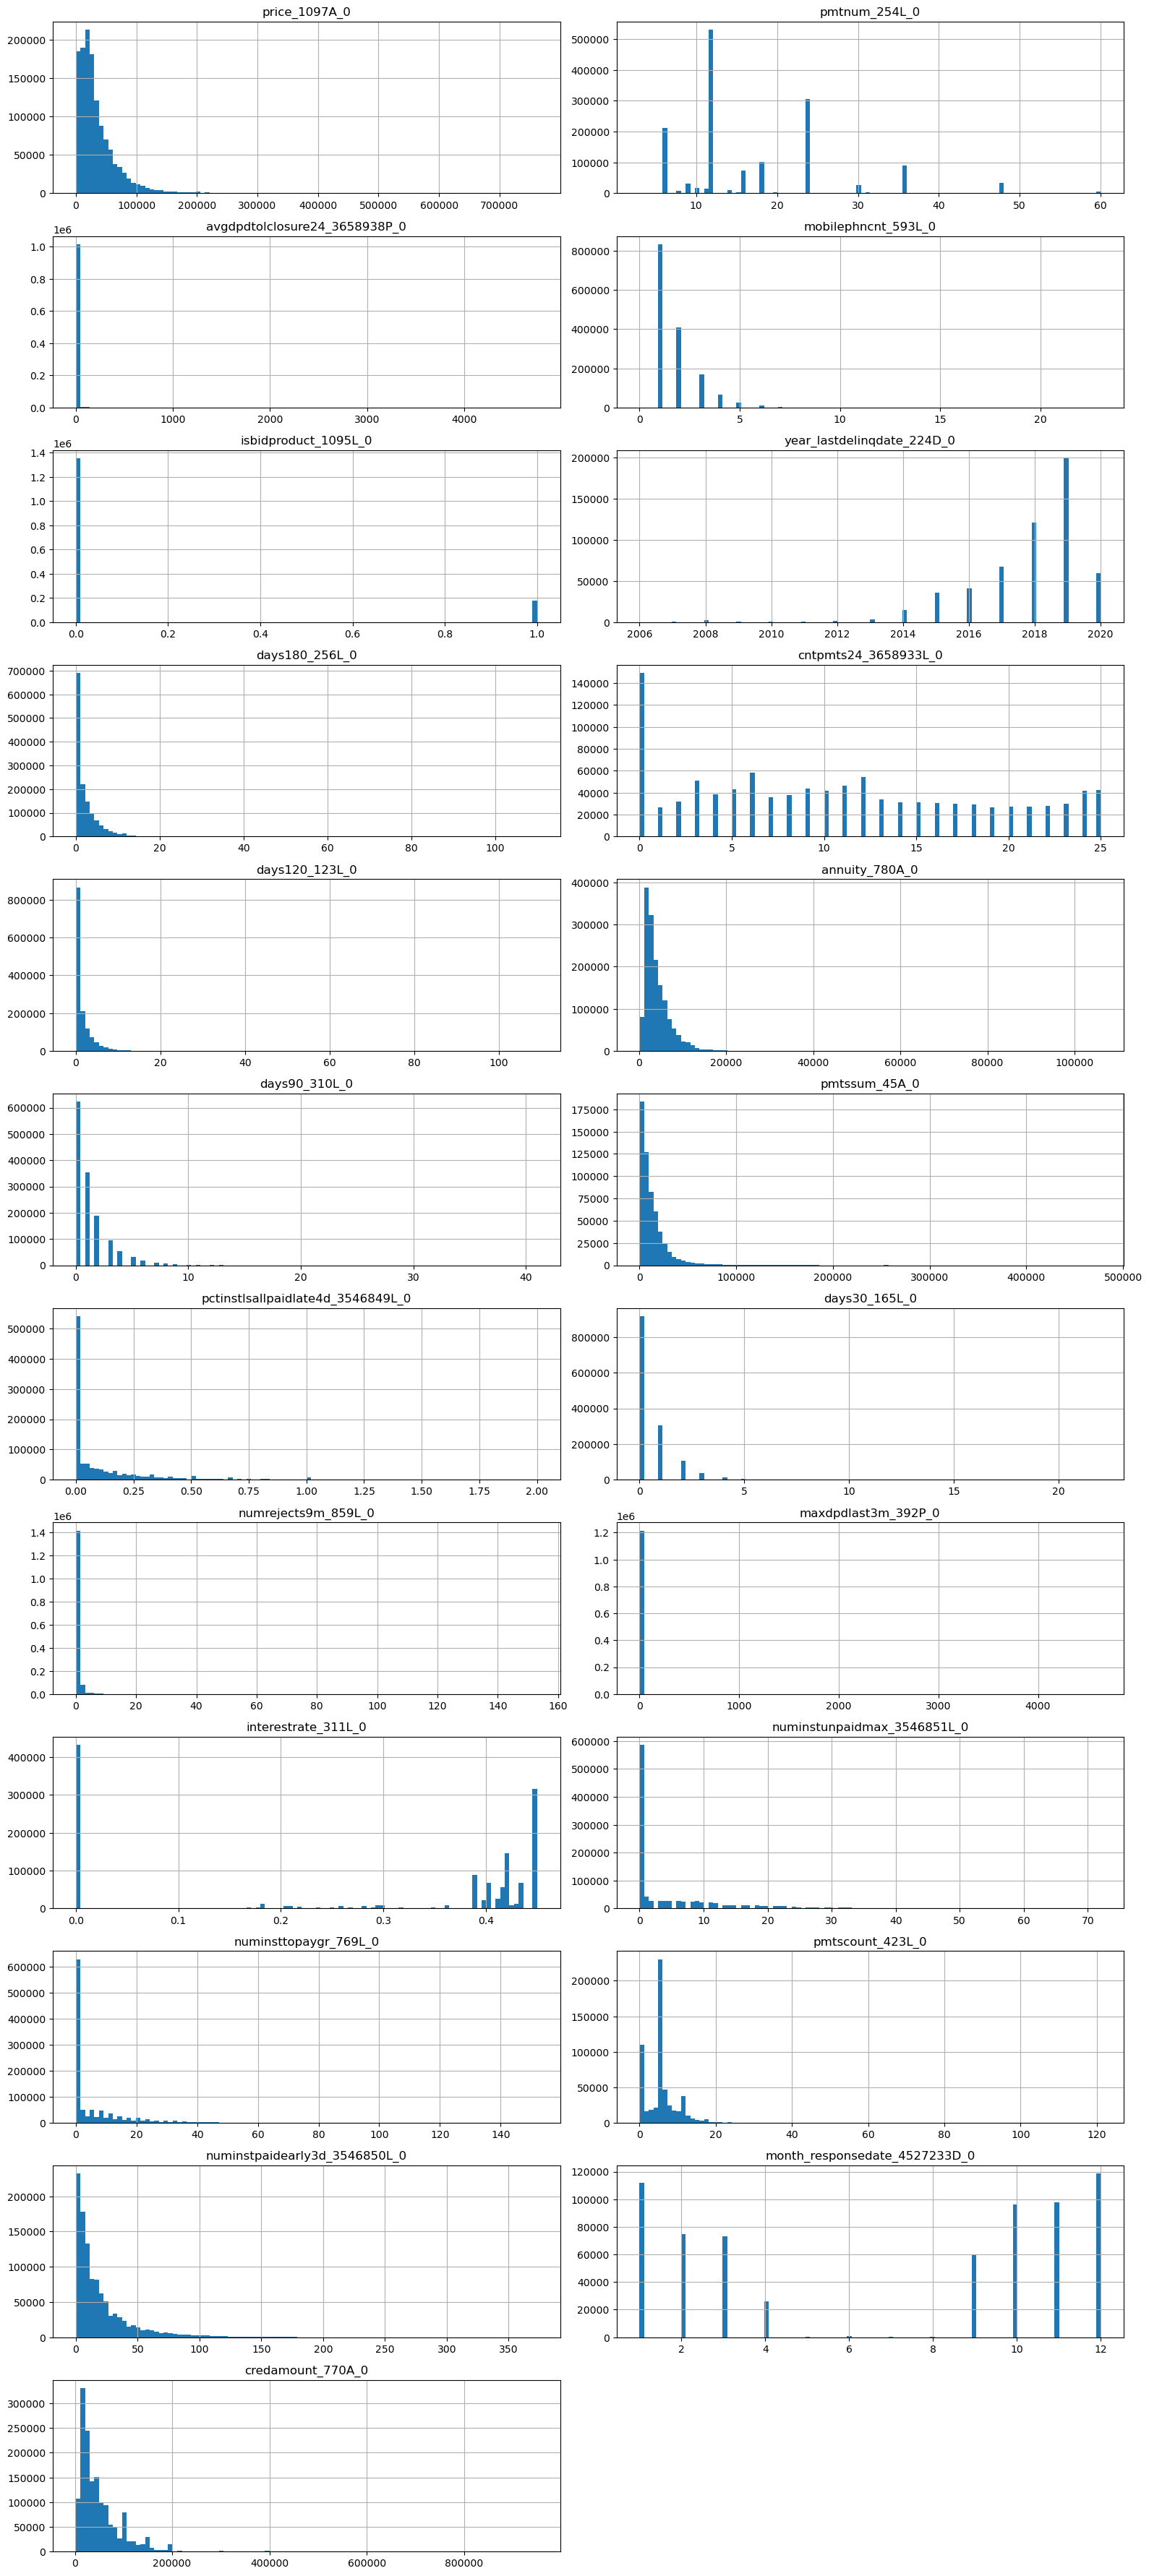

In [41]:
k = 50
topk_features = fimps.sort_values('fimp_mean', ascending=False).reset_index(drop=True).iloc[:k].query('depth=="0"')
display(topk_features[['processed_Variable', 'fimp_mean', 'Variable', 'Description', 'transform', 'depth']])

_ = depth_data[topk_features['processed_Variable'].to_list()].hist(bins=100, layout=(len(topk_features)+1, 2), figsize=(16, 16*5))
plt.tight_layout()
plt.show()

### plot probability per week

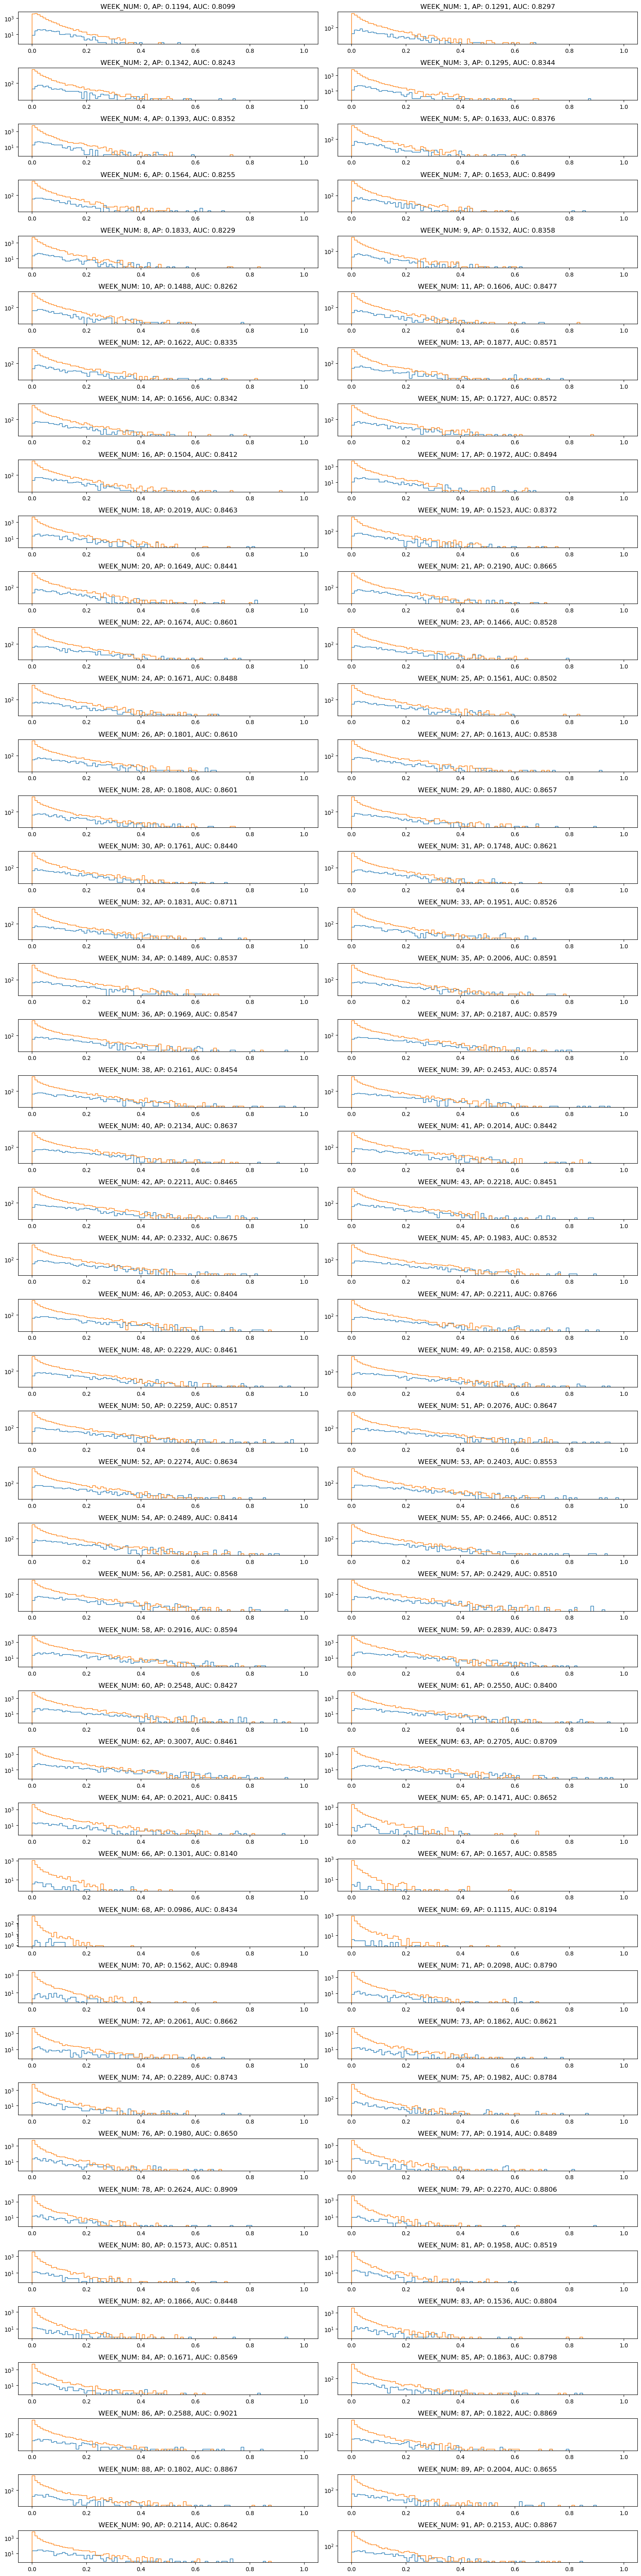

In [42]:
def plot_probability(oof):
    _, axs = plt.subplots(92//2, 2, figsize=(16, 64))
    bins = np.linspace(0, 1, 100)
    for i, (_, g) in enumerate(oof.groupby('WEEK_NUM')[['probability', 'target']]):
        ap = average_precision_score(g['target'], g['probability'])
        auc = roc_auc_score(g['target'], g['probability'])
        axs[i//2, i%2].hist(g.query('target==1')['probability'], bins=bins, histtype='step')
        axs[i//2, i%2].hist(g.query('target==0')['probability'], bins=bins, histtype='step')
        axs[i//2, i%2].set_yscale('log')
        axs[i//2, i%2].set_title(f'WEEK_NUM: {i}, AP: {ap:.4f}, AUC: {auc:.4f}')
    plt.tight_layout()
    plt.show()


plot_probability(oof)

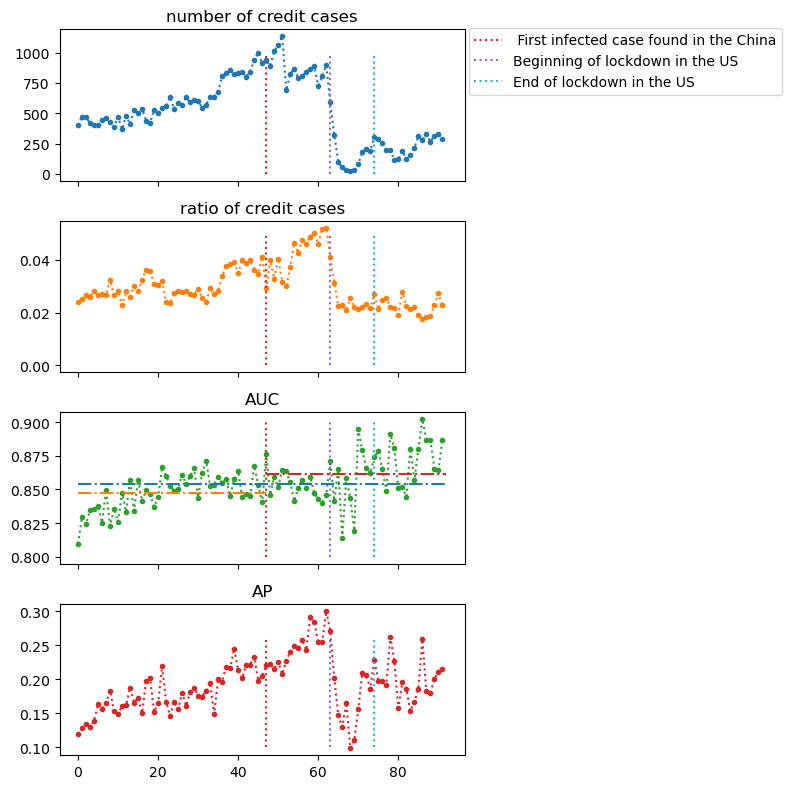

In [43]:
num_target_per_week = oof.groupby('WEEK_NUM')['target'].sum()
ratio_target_per_week = oof.groupby('WEEK_NUM')['target'].agg(lambda x: x.sum() / len(x))
auc_per_week = oof.groupby('WEEK_NUM')[['probability', 'target']].apply(lambda x: roc_auc_score(x['target'], x['probability']))
ap_per_week = oof.groupby('WEEK_NUM')[['probability', 'target']].apply(lambda x: average_precision_score(x['target'], x['probability']))

_, axs = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
axs[0].plot(num_target_per_week, marker='.', linestyle=':')
axs[1].plot(ratio_target_per_week, marker='.', linestyle=':', color='tab:orange')
axs[2].plot(auc_per_week, marker='.', linestyle=':', color='tab:green')
axs[3].plot(ap_per_week, marker='.', linestyle=':', color='tab:red')

axs[0].set_title('number of credit cases')
axs[1].set_title('ratio of credit cases')
axs[2].set_title('AUC')
axs[3].set_title('AP')

axs[0].vlines(47, 0, 1000, color='tab:red', linestyle=':', label=' First infected case found in the China')
axs[1].vlines(47, 0, 0.05, color='tab:red', linestyle=':')
axs[2].vlines(47, 0.8, 0.9, color='tab:red', linestyle=':')
axs[3].vlines(47, 0.1, 0.26, color='tab:red', linestyle=':')

axs[0].vlines(63, 0, 1000, color='tab:purple', linestyle=':', label='Beginning of lockdown in the US')
axs[1].vlines(63, 0, 0.05, color='tab:purple', linestyle=':')
axs[2].vlines(63, 0.8, 0.9, color='tab:purple', linestyle=':')
axs[3].vlines(63, 0.1, 0.26, color='tab:purple', linestyle=':')

axs[0].vlines(74, 0, 1000, color='tab:cyan', linestyle=':', label='End of lockdown in the US')
axs[1].vlines(74, 0, 0.05, color='tab:cyan', linestyle=':')
axs[2].vlines(74, 0.8, 0.9, color='tab:cyan', linestyle=':')
axs[3].vlines(74, 0.1, 0.26, color='tab:cyan', linestyle=':')

axs[2].hlines(auc_per_week.mean(), 0, 92, color='tab:blue', linestyle='-.')
axs[2].hlines(auc_per_week[:47].mean(), 0, 47, color='tab:orange', linestyle='-.')
axs[2].hlines(auc_per_week[47:].mean(), 47, 92, color='tab:red', linestyle='-.')

axs[0].legend(bbox_to_anchor=(1.01, 1.01), borderaxespad=0)

plt.tight_layout()
plt.show()

### save selected features

In [44]:
selected_features = fimps.sort_values('fimp_mean', ascending=False).iloc[:300].reset_index(drop=True)
display(selected_features)

selected_features.to_csv(paths.feature_dir.joinpath('selected_features.csv'), index=False)

processed_Variable  fold_1_fimp  fold_2_fimp  \
0                first_incometype_1044T_1     2.373700     2.295061   
1                           price_1097A_0     2.090621     2.346714   
2                 year_first_birth_259D_1     1.814685     2.146729   
3                        first_sex_738L_1     1.986439     2.088416   
4                           pmtnum_254L_0     2.027380     2.000556   
..                                    ...          ...          ...   
295  first_first_cacccardblochreas_147M_2     0.047713     0.035007   
296       year_lastapplicationdate_877D_0     0.041478     0.042233   
297           sum_ratio_pmts_month_706T_2     0.028348     0.033038   
298             max_residualamount_488A_1     0.016874     0.038283   
299            median_personindex_1023L_1     0.006243     0.008371   

     fold_3_fimp  fold_4_fimp  fold_5_fimp  fimp_mean  fimp_std  \
0       2.333860     2.386170     2.362060   2.350170  0.032540   
1       1.964416     1.988609     1.864001   2.050872  0.164545   
2       2.153961     1.993088     2.114035   2.044500  0.128628   
3       1.980769     2.044951     1.972626   2.014640  0.044876   
4       2.162102     1.577300     2.055565   1.964581  0.201254   
..           ...          ...          ...        ...       ...   
295     0.049492     0.054861     0.044474   0.046309  0.006578   
296     0.030510     0.039590     0.043192   0.039401  0.004600   
297     0.036308     0.021456     0.031899   0.030210  0.005062   
298     0.015361     0.029374     0.016138   0.023206  0.009132   
299     0.017491     0.009391     0.006134   0.009526  0.004173   

                     Variable  \
0            incometype_1044T   
1                 price_1097A   
2                  birth_259D   
3                    sex_738L   
4                 pmtnum_254L   
..                        ...   
295    cacccardblochreas_147M   
296  lastapplicationdate_877D   
297           pmts_month_706T   
298       residualamount_488A   
299         personindex_1023L   

                                                                                        Description  \
0                                                                      Type of income of the person   
1                                                                                     Credit price.   
2                                                                      Date of birth of the person.   
3                                                                             Gender of the client.   
4                                                 Total number of loan payments made by the client.   
..                                                                                              ...   
295                                                                           Card blocking reason.   
296                                                        Date of previous customer's application.   
297  Month of payment for active contract (num_group1 - terminated contract, num_group2 - payment).   
298                                                           Residual amount of a closed contract.   
299                                          Order of the person specified on the application form.   

    transform depth  smaller_than_q50  ratio_nan  
0           T     1             False   0.000000  
1           A     0             False   0.146228  
2           D     1             False   0.000000  
3           L     1             False   0.000000  
4           L     0             False   0.029446  
..        ...   ...               ...        ...  
295         M     2              True   0.199872  
296         D     0              True   0.199872  
297         T     2              True   0.092602  
298         A     1              True   0.680962  
299         L     1              True   0.000000  

[300 rows x 14 columns]

0 91


<Axes: xlabel='WEEK_NUM'>

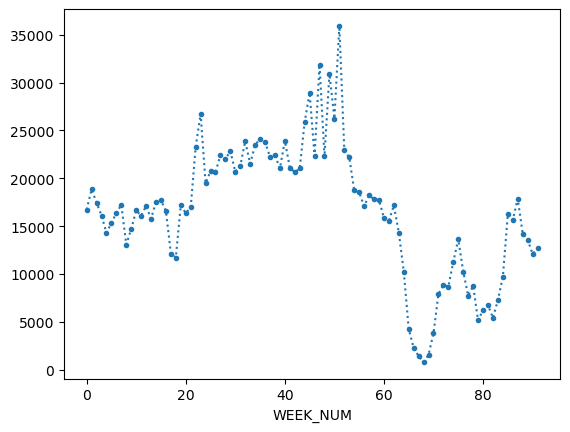

In [50]:
print(depth_data['WEEK_NUM'].min(), depth_data['WEEK_NUM'].max())
depth_data['WEEK_NUM'].value_counts().sort_index().plot(marker='.', linestyle=':')